# K Means Practice on Images

In [ ]:
# K Means practice 
import torch
import torchvision
import torchvision.transforms as transforms

# Load dataset


transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset),
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset),
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Prepare data 
import collections
import numpy as np
from pdb import set_trace
_,labels = next(iter(trainloader))

# Initialization
num_labels = dict(collections.Counter(labels.detach().cpu().numpy()))
print(num_labels)



{2: 5000, 8: 5000, 7: 5000, 4: 5000, 5: 5000, 6: 5000, 0: 5000, 3: 5000, 1: 5000, 9: 5000}


In [ ]:
# Prepare training image data
training_images = []
training_labels = []
sampled_idxs = np.random.choice(np.arange(num_labels[0]), 
                                size = 100,
                                replace = True)


for idx in num_labels:
  for idxs in sampled_idxs:
    images,label = trainset[idx * num_labels[idx] + idxs]
    images = images.cpu().numpy()
    if training_images ==[]:
      training_images = images.reshape(tuple([1] + list(images.shape)))
      training_labels = [label]
    else:
      training_images = np.concatenate((training_images, 
                                        images.reshape(tuple([1] 
                                                    + list(images.shape)))),
                                        axis = 0)
    
      training_labels.append(label)

training_labels = np.array(training_labels)
print(training_images.shape)
print(training_labels.shape)

<ipython-input-5-5477b0ac38a0>:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if training_images ==[]:


(1000, 3, 32, 32)
(1000,)


In [ ]:
import numpy as np

# stuff = np.arange(225).reshape((15,15))
# np.utils.

# patches = data.s
#   patch_shape = (data.shape[0], data.shape[1], patch_shape[0],patch_shape[1])


In [ ]:
# TODO: Modify this cell

import numpy as np
import collections
from typing import *
from tqdm import tqdm

def patchify(data, patch_shape):
  '''
  Convert a batch of images into a batch of non-overlapping patches extracted
  from the image 
  '''
  
  patches = data.copy().reshape((data.shape[0], data.shape[1], 
                                 data.shape[2]//patch_shape[0], patch_shape[0],
                                 data.shape[3]//patch_shape[1], patch_shape[1]))
  
  patches = patches.swapaxes(3,4)
  patches = patches.reshape((data.shape[0], data.shape[1], -1,
                             patch_shape[0], patch_shape[1]))\
                    .transpose((0,2,1,3,4))\
                    .reshape((-1, data.shape[1], patch_shape[0], patch_shape[1]))
  return patches.copy()

def sliding_patches(data, patch_shape, stride):
    working_input = data.copy()
    
    output_size = (data.shape[0], data.shape[1],
                   ((data.shape[2] - patch_shape[0])// stride[0]) + 1,
                   ((data.shape[3] - patch_shape[1])// stride[1]) + 1) 
    
    in_b, in_c, out_h, out_w = output_size

    out_b, out_c, _, _ = data.shape

    print(working_input.strides)
    batch_str, channel_str, kern_h_str, kern_w_str = working_input.strides

    patches = np.lib.stride_tricks.as_strided(
        working_input,
        (out_b, out_c, out_h, out_w, patch_shape[0], patch_shape[1]),
        (batch_str, channel_str, stride[0] * kern_h_str, stride[1]* kern_w_str, kern_h_str, kern_w_str)
    )

    print(patches.shape)
    patches = patches.reshape((out_b, out_c, -1, patch_shape[0], patch_shape[1]))\
                      .transpose((0,2,1,3,4))\
                      .reshape((-1, out_c, patch_shape[0], patch_shape[1]))

    return patches


class KMeans:

  def __init__(self, num_clusters = 10, 
               max_iters = 100, 
               image_shape = None, 
               initialization = 'random' 
               ):
    self.num_clusters = num_clusters
    self.max_iters = max_iters
    self.original_image_shape = image_shape
    self.labels_matrix = None
    self.initialization = initialization
    

  def compute_distances(self, data:np.ndarray, centroids:np.ndarray):
    '''
      Commputes the distance of the data from each centroid
      data: shape(n,d)
      centroids: (k,d)
    '''

    data_ = data.reshape((data.shape[0], 1,data.shape[1]))
    data_ = np.repeat(data_, repeats = centroids.shape[0] ,axis = 1 )
    centroids_ = centroids.reshape((1, centroids.shape[0], -1))

    distances = np.square(data_ - centroids_).mean(axis = -1)

    return distances

  def compute_centres(self, data, cluster_id, num_clusters):
    '''
     Computes new centroids given the cluster ids
    '''

    centroids = [np.mean( data[np.where(cluster_id == j)[0], :],axis = 0)\
             for j in range(num_clusters)]

    return np.array(centroids)
    


  def compute_cluster_id(self, data, centroids):
    '''
      Compute cluster ids for each data element given the centroids
    '''

    distances = self.compute_distances(data, centroids)
    cluster_id = np.argmin(distances, axis = -1)
    return cluster_id

  def init_centroids(self, data, num_clusters):
    '''
      Initialize centroids given the data 
    ''' 

    M = data.shape[0]
    probs = np.ones((M,))/M
    if self.initialization == 'random':
      centroids_idx = np.random.choice(np.arange(M),
                                       size = num_clusters, 
                                       p = probs)
      centroids = data[centroids_idx, :]
    
    else:
      
      idxs = np.zeros(self.num_clusters)
      for j in range(self.num_clusters):
        sampled = np.random.choice(np.arange(M),
                                       size = 1, 
                                       p = probs)
        
        idxs[j] = sampled.copy()
        probs[sampled] = 0
        probs *= np.exp(np.square(data - data[[idx], :]).mean(axis = -1) - 0.3)
        probs /= probs.sum()

      centroids = data[idxs.astype(np.int), :]
    return centroids

  def fit(self, training_data, labels = None):
    '''
      Fit training data to compute cluster centres and associated data centres
      corresponding to each cluster -  only if entire image is being operated upon
      and not individual patches 
    '''
    
    iter = 0
    prev_cluster_id = np.zeros(self.num_clusters)

    self.centroids = self.init_centroids(training_data.copy(), self.num_clusters)
    cluster_id = self.compute_cluster_id(training_data.copy(), self.centroids.copy())

    done = False
    
  

    with tqdm(total = self.max_iters) as pbar:
      while (iter < self.max_iters) and not done:
        iter += 1

        self.centroids = self.compute_centres(training_data.copy(), 
                                              cluster_id,
                                              self.num_clusters)
        
        prev_cluster_id = cluster_id
        
        cluster_id = self.compute_cluster_id(training_data.copy(),
                                            self.centroids)

        
        if np.all(prev_cluster_id == cluster_id):
          done = True
        pbar.update(1)

    
    if labels is not None:
      max_labels = len(set(labels))
      self.labels_matrix = np.zeros((self.num_clusters, max_labels))

      for j in range(self.num_clusters):
        freq = collections.Counter(labels[np.where(cluster_id == j)[0]])
        for k,v in dict(freq).items():
          self.labels_matrix[j][k] = v
        self.labels_matrix[j,:] /= self.labels_matrix[j,:].sum() 
      
      print(self.labels_matrix.shape)
    

  def predict(self, test_data):
    '''
      Predict the test data labels 
    '''

    if self.labels_matrix is None:
      raise NotImplementedError(" No training labels provided")

    cluster_id  = self.compute_cluster_id(test_data.copy(), self.centroids.copy())
    predictions = self.labels_matrix[cluster_id,:]
    print(predictions.shape)
    return predictions

  def visualize_centroids(self):
    '''
    Visualize the centroids computed
    '''

    from matplotlib.pyplot import imshow
    import matplotlib.pyplot as plt

    
    for j in range(self.centroids.shape[0]):
      plt.figure()
      imshow(self.centroids[j].reshape(self.original_image_shape).transpose((1,2,0)))

In [ ]:
# print(model_patches.centroids.shape)
# # model_patches.original_image_shape = (3,8,4)
# # model_patches.visualize_centroids()

# from matplotlib import pyplot as plt
# plt.figure()
# plt.imshow(training_images[0].transpose((1,2,0)))
# plt.figure()
# plt.imshow(patches[20].reshape((3,8,4)). transpose((1,2,0)))

In [ ]:
sliding_p = sliding_patches(training_images, patch_shape = (8,4), stride = (2,2))
print(sliding_p.shape)


(12288, 4096, 128, 4)
(1000, 3, 13, 15, 8, 4)
(195000, 3, 8, 4)


In [ ]:
print(training_images.shape)

(1000, 3, 32, 32)


In [ ]:
# Fitting K Means on Patches

patches = patchify(training_images, patch_shape = (8,4))
patches_real_shape = patches[0].shape
patches = patches.reshape((patches.shape[0],-1))
print(patches.shape)



model_patches = KMeans(num_clusters = 30,
                       max_iters = 100, 
                       image_shape = patches_real_shape)

model_patches.fit(patches, labels = None)

# visualize centroids
model_patches.visualize_centroids()


(32000, 96)


TypeError: ignored

# Metrics Practice 
(AuPRC AuROC on predicted labels based on KMeans classifier)


In [ ]:
# Prepare the training dataset

# Prepare data 
import collections
import numpy as np
from pdb import set_trace
_,labels = next(iter(trainloader))

# Initialization
num_labels = dict(collections.Counter(labels.detach().cpu().numpy()))
print(num_labels)

_,labels_test = next(iter(testloader))

# Initialization
num_labels_test = dict(collections.Counter(labels_test.detach().cpu().numpy()))
print(num_labels_test)


{7: 5000, 0: 5000, 3: 5000, 2: 5000, 8: 5000, 9: 5000, 6: 5000, 5: 5000, 1: 5000, 4: 5000}
{3: 1000, 8: 1000, 0: 1000, 6: 1000, 1: 1000, 9: 1000, 5: 1000, 7: 1000, 4: 1000, 2: 1000}


In [ ]:
# Prepare training image data
training_images = []
training_labels = []
sampled_idxs = np.random.choice(np.arange(num_labels[0]), 
                                size = 100,
                                replace = True)


for idx in num_labels:
  for idxs in sampled_idxs:
    images,label = trainset[idx * num_labels[idx] + idxs]
    images = images.cpu().numpy()
    if training_images ==[]:
      training_images = images.reshape(tuple([1] + list(images.shape)))
      training_labels = [label]
    else:
      training_images = np.concatenate((training_images, 
                                        images.reshape(tuple([1] 
                                                    + list(images.shape)))),
                                        axis = 0)
    
      training_labels.append(label)

training_labels = np.array(training_labels)
print(training_images.shape)
print(training_labels.shape)

<ipython-input-34-5477b0ac38a0>:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if training_images ==[]:


(1000, 3, 32, 32)
(1000,)


In [ ]:
# Prepare the testing data

testing_images = []
testing_labels = []
sampled_idxs_test = np.random.choice(np.arange(num_labels[0]), 
                                size = 100,
                                replace = True)


for idx in num_labels:
  for idxs in sampled_idxs:
    images,label = trainset[idx * num_labels[idx] + idxs]
    images = images.cpu().numpy()
    if testing_images ==[]:
      testing_images = images.reshape(tuple([1] + list(images.shape)))
      testing_labels = [label]
    else:
      testing_images = np.concatenate((testing_images, 
                                        images.reshape(tuple([1] 
                                                    + list(images.shape)))),
                                        axis = 0)
    
      testing_labels.append(label)

testing_labels = np.array(testing_labels)
print(testing_images.shape)
print(testing_labels.shape)

<ipython-input-35-96eda7bbf09e>:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if testing_images ==[]:


(1000, 3, 32, 32)
(1000,)


 24%|██▍       | 24/100 [00:09<00:30,  2.48it/s]


(30, 10)


<ipython-input-41-69fbb6038b34>:101: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  centroids = data[idxs.astype(np.int), :]
 26%|██▌       | 26/100 [00:10<00:30,  2.43it/s]


(30, 10)


<ipython-input-41-69fbb6038b34>:176: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


(1000, 10)
(1000, 10)


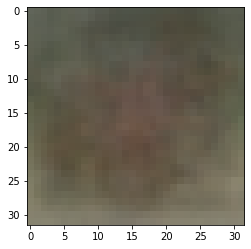

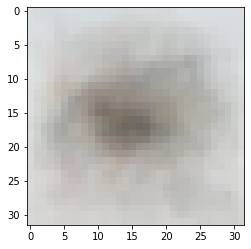

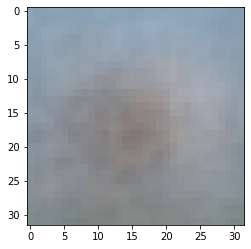

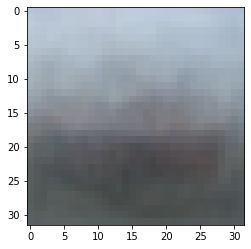

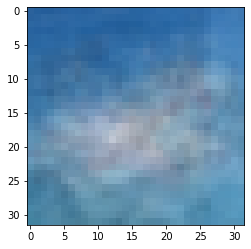

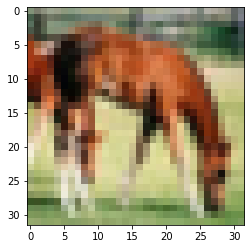

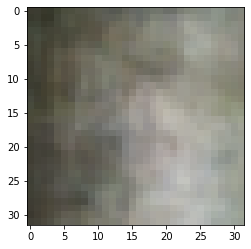

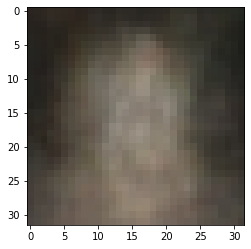

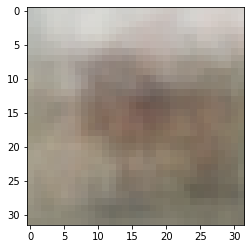

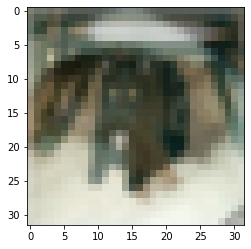

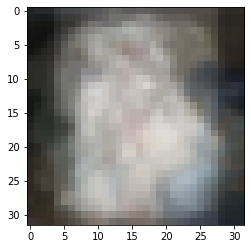

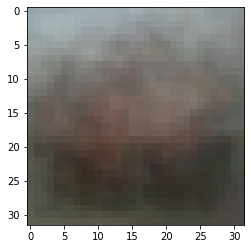

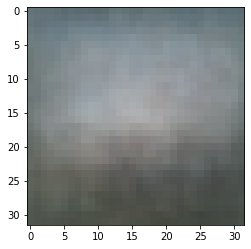

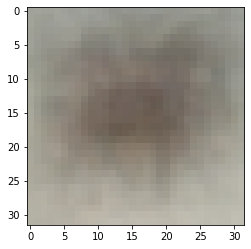

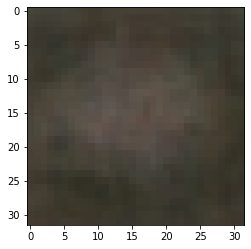

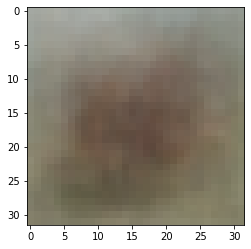

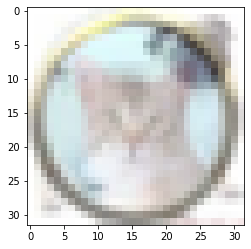

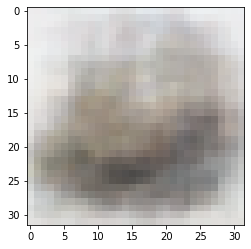

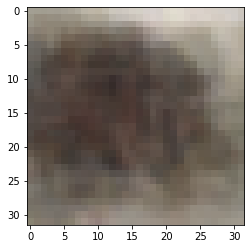

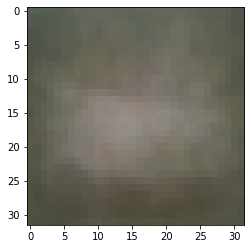

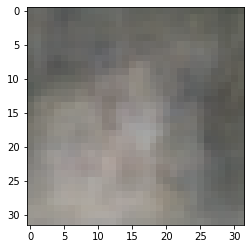

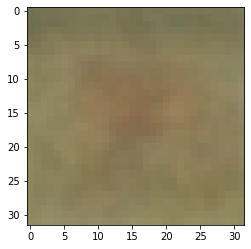

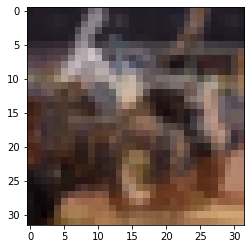

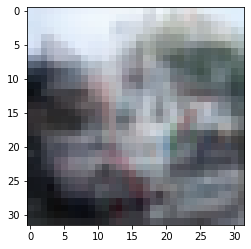

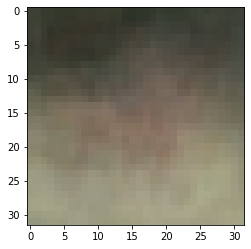

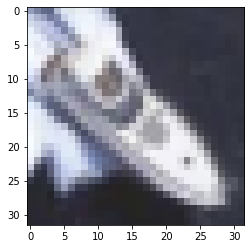

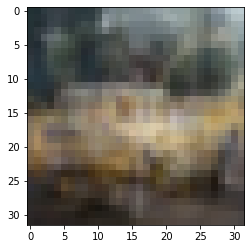

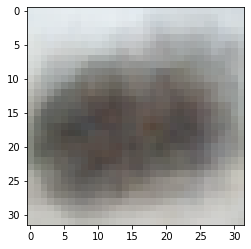

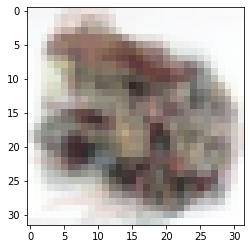

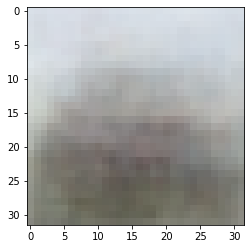

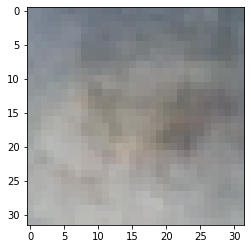

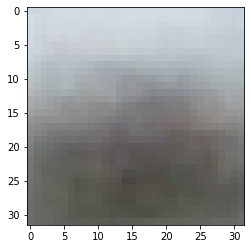

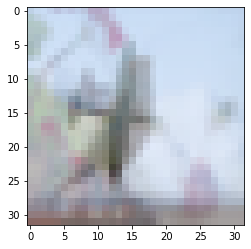

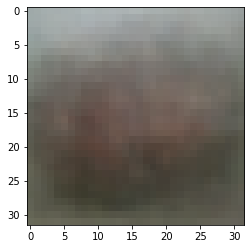

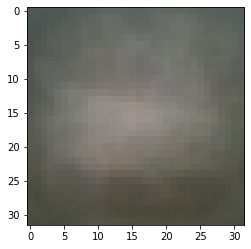

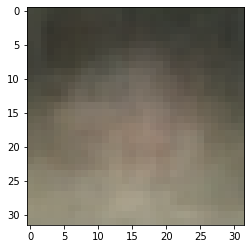

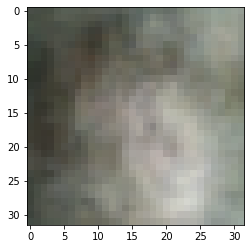

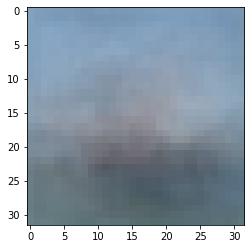

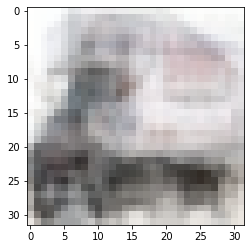

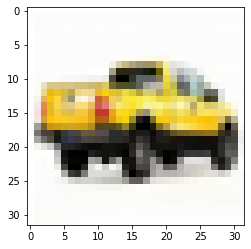

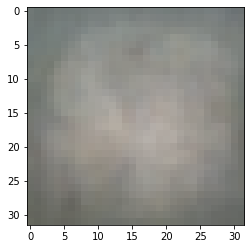

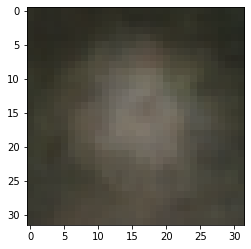

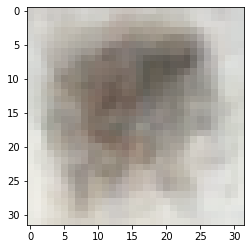

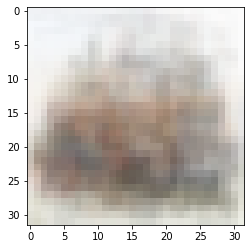

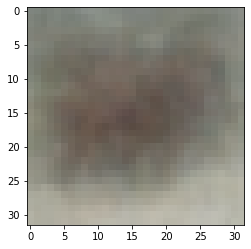

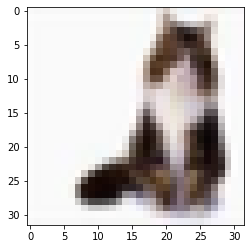

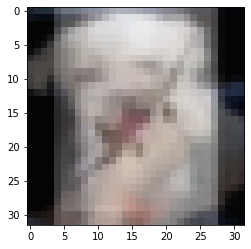

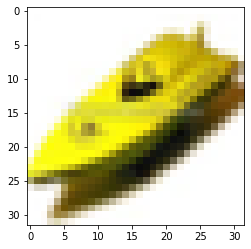

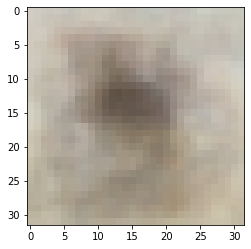

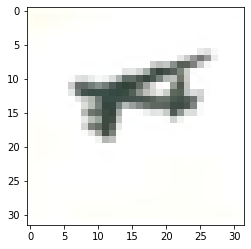

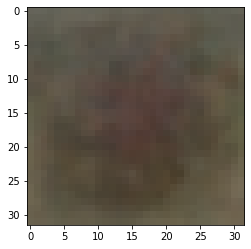

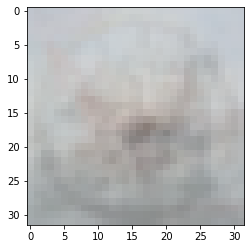

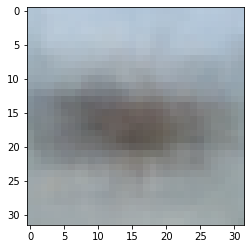

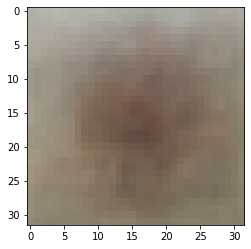

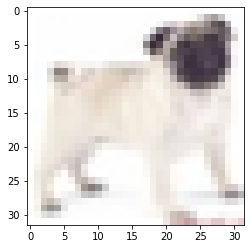

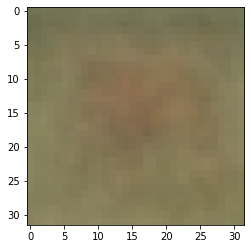

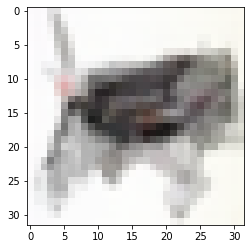

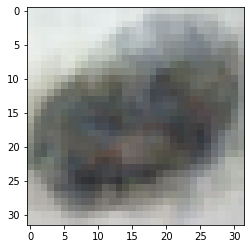

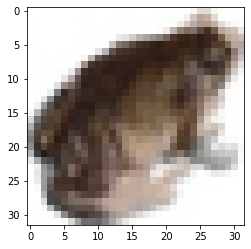

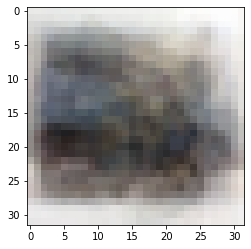

In [ ]:
# Training the KMeans model with 2 different initializations

model_random = KMeans(num_clusters = 30,
                      max_iters = 100, 
                      image_shape = training_images[0].shape)

model_dist = KMeans(num_clusters = 30,
                    max_iters = 100, 
                    image_shape = training_images[0].shape,
                    initialization = 'dist'
                   )
training_images_ = training_images.copy().reshape((training_images.shape[0],-1))
model_random.fit(training_images_.copy(), training_labels.copy())
model_dist.fit(training_images_.copy(),training_labels.copy())

# visualize centroids
model_random.visualize_centroids()
model_dist.visualize_centroids()

# Obtain the testing labels
testing_images_ = testing_images.copy().reshape((testing_images.shape[0],-1))
labels_pred_random = model_random.predict(testing_images_.copy())
labels_pred_dist = model_dist.predict(testing_images_.copy())

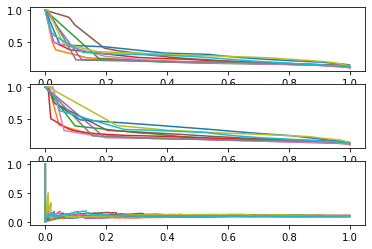


Statistics for Classes
No Skill AuPRC [0.104880059650237, 0.08401160852279883, 0.1111732277890347, 0.10938030559666584, 0.08779273077835001, 0.1233274774450199, 0.09516861223505074, 0.10340769542899056, 0.12085925375176627, 0.11099765894691664]
No Skill AuROC [0.5152708619505494, 0.48862390350877183, 0.5472400541508362, 0.49856605762117573, 0.46972562727446854, 0.544122262990984, 0.533094211367697, 0.4833657677694375, 0.54754970241864, 0.4890539148351648]
Random K Means AuPRC [0.2876759151607363, 0.18850760389582205, 0.17387380762992233, 0.22496019381318552, 0.17198659104020061, 0.2891969238902615, 0.18881320138632077, 0.18291566510774923, 0.2855016266065538, 0.24733735139375937]
Random K Means AuROC [0.8028685182005495, 0.7321072567783093, 0.6820439757194638, 0.70581886723619, 0.7159488124880291, 0.7340920652444501, 0.7562433670522173, 0.6753827778292611, 0.804688489299734, 0.7441996480082418]
Dist Init K Means AuPRC [0.3288778571424513, 0.19118355582744126, 0.21463522068651356, 0.21

In [ ]:
# Scikit Learn Metrics

from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, average_precision_score
import matplotlib.pyplot as plt

num_classes = len(set(dict(num_labels).keys()))

testing_labels_onehot = np.zeros((testing_labels.shape[0], num_classes))
testing_labels_onehot[np.arange(testing_labels.shape[0]),testing_labels] = 1.0

# For model 1

_, axes = plt.subplots(nrows=3, ncols=1)

mean_average_precision_ns = 0
mean_average_precision_1 = 0
mean_average_precision_2 = 0

ap_ns = []
ap_1 = []
ap_2 = []

roc_ns = []
roc_1 = []
roc_2 = []

for j in range(num_classes):
  #print("\nStatistics for Class {}".format(j))
  preds = np.random.random(labels_pred_random.shape)
  preds = preds / preds.sum(axis = -1).reshape((preds.shape[0],1))
  no_skill_model = preds.copy()

  ns_precision_1, ns_recall_1, _ = precision_recall_curve(testing_labels_onehot[:, j].copy(), 
                                                          no_skill_model[:, j].copy())

  axes[2].plot(ns_recall_1, ns_precision_1, label = "noskill{}".format(j))
  ns_auc = average_precision_score(testing_labels_onehot[:, j].copy(), 
                                  no_skill_model[:, j].copy())

  # print("No Skill AuPRC {}".format(ns_auc))
  mean_average_precision_ns += ns_auc
  ap_ns.append(ns_auc)

  ns_auc = roc_auc_score(testing_labels_onehot[:, j].copy(), no_skill_model[:, j])
  #print("No Skill AuROC {}".format(ns_auc))
  roc_ns.append(ns_auc)

  lr_precision_1, lr_recall_1, _ = precision_recall_curve(testing_labels_onehot[:, j].copy(), 
                                                          labels_pred_random[:, j].copy())
  axes[0].plot(lr_recall_1,lr_precision_1,label = "class{}".format(j))

  lr_auc = average_precision_score(testing_labels_onehot[:, j].copy(), 
                                  labels_pred_random[:, j].copy())
  ap_1.append(lr_auc)
  ##print("Random Init K Means AuPRC {}".format(lr_auc))

  mean_average_precision_1 += lr_auc
  
  ns_auc = roc_auc_score(testing_labels_onehot[:, j].copy(), no_skill_model[:, j])
  lr_auc = roc_auc_score(testing_labels_onehot[:, j].copy(), labels_pred_random[:, j].copy())

  #print("Random Init K Means AuROC {}".format(lr_auc))
  roc_1.append(lr_auc)


  # For model 2



  lr_precision_2, lr_recall_2, _ = precision_recall_curve(testing_labels_onehot[:, j].copy(), 
                                                          labels_pred_dist[:, j].copy())

  lr_auc = average_precision_score(testing_labels_onehot[:, j].copy(), 
                                  labels_pred_dist[:, j].copy())

  axes[1].plot(lr_recall_2,lr_precision_2,label = "class{}".format(j))

  # print(lr_recall_2)
  # print(lr_precision_2)
  #print("Dist Init K Means AuPRC {}".format(lr_auc))
  mean_average_precision_2 += lr_auc
  ap_2.append(lr_auc)

  lr_auc = roc_auc_score(testing_labels_onehot[:, j].copy(), labels_pred_dist[:, j].copy())
  #print("Dist Init K Means AuROC {}".format(lr_auc))
  roc_2.append(lr_auc)

plt.show()

print("\nStatistics for Classes".format(j))

print("No Skill AuPRC {}".format(ap_ns))
print("No Skill AuROC {}".format(roc_ns))
print("Random K Means AuPRC {}".format(ap_1))
print("Random K Means AuROC {}".format(roc_1))
print("Dist Init K Means AuPRC {}".format(ap_2))
print("Dist Init K Means AuROC {}".format(roc_2))
print("MAP No Skill Model {}".format(mean_average_precision_ns/num_classes))
print("MAP Random Model {}".format(mean_average_precision_1/num_classes))
print("MAP Dist Model {}".format(mean_average_precision_2/num_classes))
                                           

In [ ]:
# AUPRC and AUROC  helper function 
from pdb import set_trace
# computer AUPRC and AUROC over labels_pred_random and labels_pred_dist
class Metrics:

  def __init__(self, num_classes = 2):
    self.num_classes = num_classes
    
    pass
  
  def _compute_prc(self, labels_gt_, labels_pred):
    # For binary classification
    # creating one_hot
    
    # labels_onehot = np.zeros((labels_gt.shape[0], self.num_classes))
    # labels_onehot[np.arange(labels_gt.shape[0]),labels_gt] = 1.0
    
    sorted_idx = np.argsort(labels_pred)[::-1]
    labels_pred = labels_pred.copy()[sorted_idx]
    labels_gt = labels_gt_.copy()[sorted_idx]

    # Thresholding
    threshold_idx = np.where(np.diff(labels_pred))[0]
    
    if threshold_idx[0] != 0:
      threshold_idx = np.concatenate(([0], threshold_idx), axis = 0)
    
    if threshold_idx[-1] != labels_gt_.shape[0] - 1:
      threshold_idx = np.concatenate((threshold_idx, [labels_gt_.shape[0] - 1])
      , axis = 0)

    tps = np.cumsum(labels_gt, axis = 0)
    fps = np.cumsum(1 - labels_gt, axis = 0)

    ps = tps + fps

    precision = tps[ps!=0] / ps[ps!=0]

    no_pos = labels_gt.sum()
    no_neg = (1 - labels_gt).sum()

    if no_pos == 0:
      recall = np.zeros(threshold_idx.shape[0])
    else:
      recall = tps / no_pos
    
    if no_neg == 0:
      fpr = np.zeros(threshold_idx.shape[0])
    else:
      fpr = fps / no_neg

    return precision, recall, fpr

  def compute_auroc(self, labels_gt, labels_pred):
    aucs = []

    for j in range(self.num_classes):

      _, recall, fpr = self._compute_prc(labels_gt[:, j], labels_pred[:, j])
      
      auc = np.sum(0.5 * (recall[1:] + recall[:-1]) * (fpr[1:] - fpr[:-1]))
      aucs.append(auc)

    return aucs

  def compute_auprc(self, labels_gt, labels_pred):
    aucs = []

    for j in range(self.num_classes):
      prec, recall, _ = self._compute_prc(labels_gt[:, j], labels_pred[:, j])
    
      auc = np.sum(prec[1:] * (recall[1:] - recall[:-1]))
      aucs.append(auc)
      
    return aucs


In [ ]:

# Test AUROC and AUPRC computation

metrics = Metrics(num_classes = len(dict(num_labels).keys()))

testing_labels_onehot = np.zeros((testing_labels.shape[0], num_classes))
testing_labels_onehot[np.arange(testing_labels.shape[0]),testing_labels] = 1.0


print("For model 1")
print("ROC {}".format(metrics.compute_auroc(testing_labels_onehot,
                                            labels_pred_random)))
print("PRC {}".format(metrics.compute_auprc(testing_labels_onehot, 
                                            labels_pred_random)))

print(" For model 2")
print("ROC {}".format(metrics.compute_auroc(testing_labels_onehot,
                                            labels_pred_dist)))
print("PRC {}".format(metrics.compute_auprc(testing_labels_onehot,
                                            labels_pred_dist)))



For model 1
ROC [0.8011890453296703, 0.7309110845295056, 0.6810013537709071, 0.7072528096150144, 0.7156555257613484, 0.7354937169204794, 0.7479412673464177, 0.6742347017576376, 0.8043455320585877, 0.7465122767857142]
PRC [0.2977143075874171, 0.20103733489642248, 0.1863696709856546, 0.24674901032160748, 0.18278087740444654, 0.31454755451645433, 0.1780005402188191, 0.1753157049161365, 0.29154275026057946, 0.25445900653412656]
 For model 2
ROC [0.8177691449175823, 0.7243570574162679, 0.7175204157386785, 0.6962778301360979, 0.6971245929898487, 0.7367925447283827, 0.7349910665108343, 0.6699410002162295, 0.8068886919083196, 0.7649381868131868]
PRC [0.3476141420988101, 0.19931273181634995, 0.2460070055897039, 0.21164816991836927, 0.18164534175470182, 0.24810214391196933, 0.1829395682609127, 0.1789935334438435, 0.31644284285065116, 0.29160664982287493]


# Broadcasting practice based on robot trajectory data:

 How would you add spatial sensor features around the agent in an egocentric map 

In [ ]:
import numpy as np

class Agent:

  def __init__(self, init_state, dt = 0.2, footprint_shape = [2,3]):
    self.state = init_state
    self.dt = dt
    self.footprint_shape = footprint_shape

  def dynamics(self, control):

    self.state[0] += control[0] * np.cos(self.state[-1]) * self.dt
    self.state[1] += control[0] * np.sin(self.state[-1]) * self.dt
    self.state[2] += control[1] * self.dt
    if self.state[2] > np.pi:
      self.state -= 2*np.pi
    elif self.state[2] <= - np.pi:
      self.state += 2*np.pi

  def get_footprint(self, control, max_vel, scale = 3.0):

    # depends on the velocity
    
    x = np.arange(self.footprint_shape[0])
    y = np.arange(self.footprint_shape[1])
    y_mesh,x_mesh = np.meshgrid(y, x)

    variance = 0.5 * (control/max_vel)
    centre_x = self.footprint_shape[0]/2
    centre_y = self.footprint_shape[1]/2
    footprint = np.exp((np.square(x_mesh - centre_x) + 
                       np.square(y_mesh - centre_y))/ (2* np.square(variance)))
    
    return footprint*scale

def collect_trajectory(horizon, footprint):

    init_state = np.random.random((3)) * np.array([2,2,2*np.pi]) - np.array([1,1,np.pi])

    agent = Agent(init_state, dt = 0.2, footprint_shape=footprint)

    trajectory_data = np.zeros((int(horizon//agent.dt) + 1, len(agent.state)))
    
    trajectory_data[0,:] = agent.state


    footprints = np.zeros((int(horizon//agent.dt) + 1,
                           agent.footprint_shape[0], 
                           agent.footprint_shape[1]))
    footprints[0, :, :] = agent.get_footprint(control = 0, 
                                              max_vel = 2.0, 
                                              scale  = 5.0 )

    for j in range(int(horizon//agent.dt)):
      
      control = np.random.random((2))* [2,0.5]
      agent.dynamics(control)
      trajectory_data[j+1,:] = agent.state
      footprints[j+1, :, :] = agent.get_footprint(control = control[0], 
                                              max_vel = 2.0, 
                                              scale  = 5.0 )

    return trajectory_data,footprints


In [ ]:
# Collect trajectory Data

horizon = 100
footprint = [2,3]
trajectory_agent, footprint_agent = collect_trajectory(horizon = horizon,
                                                       footprint = [2,3])

print(trajectory_agent.shape)
print(trajectory_agent)
trajectory_agent.max()
print(footprint_agent.shape)

(500, 3)
[[  0.61487621  -0.48617876   3.05787393]
 [  0.57349157  -0.48270598   3.08204909]
 [  0.42218259  -0.47368584   3.088909  ]
 ...
 [-22.66801266 -23.8655593    2.5688503 ]
 [-22.87097964 -23.73467718   2.62306121]
 [-22.92819127 -23.70203146   2.6973683 ]]
(500, 2, 3)


<ipython-input-14-00e70e1563b5>:31: RuntimeWarning: divide by zero encountered in true_divide
  footprint = np.exp((np.square(x_mesh - centre_x) +
<ipython-input-14-00e70e1563b5>:31: RuntimeWarning: overflow encountered in exp
  footprint = np.exp((np.square(x_mesh - centre_x) +


In [ ]:
# Spatially queue the egocentric footprint of the agent on a given large map of a fixed size
# Spatial queuing refers to drawing the footprint of the the agent phyisically over the
# visited states in the large map,
 
map_lb = np.min(trajectory_agent[:, :2],axis = 0) - np.max(footprint)
map_ub = np.max(trajectory_agent[:, :2],axis = 0) + np.max(footprint)
discr = 0.02
distance_thresh = 0.5

map_size = ((map_ub - map_lb) / discr).astype(np.int) + 1
# print(map_ub)
# print(map_lb)

spatial_map = np.array(map_size)
print(map_size)

[1953 1855]


<ipython-input-16-5240249c6535>:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  map_size = ((map_ub - map_lb) / discr).astype(np.int) + 1


In [ ]:
# Write the spatial queuing algorithm here

indices = np.where(np.linalg.norm(
    np.diff(trajectory_agent)[:,:2], axis=-1) > distance_thresh)

trajectory_queued = trajectory_agent[indices, :]
footprints_queued = footprint_agent[indices, :]





In [ ]:
# Spatially queue in a receeding horizon manner

In [ ]:
# Spatially queue in a appropriate manner